# "Predicting Success in Film: What Drives High Ratings?"
# Elizabeth Sexton, Victor Alamillo, Jyszelle Martinez, Hengliang Wang
# To examine: Genre, Runtime, Title (Movie), Years/decades, Country (US), Cast/Crew

In [1]:
# IMPORTS AND SETTING UP SPARKS

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, explode, avg, floor, sum, count, when, expr, array, size, desc, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Importing training/testing libraries
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initializing SparkSession, adjusted memory to avoid out-of-memory errors
spark = SparkSession.builder.appName("IMDb Trends").config("spark.executor.memory", "4g").config("spark.driver.memory", "4g").getOrCreate()

In [2]:
# LOADING DATA & PREPROCESSING

base_path = "/home/jovyan/exercise/Final Project/"

# Defining a list of genres we want to focus on (more common genres known to people)
top_genres = [
    "Drama", "Comedy", "Action", "Romance", "Thriller",
    "Adventure", "Animation", "Family", "Fantasy", "History",
    "Horror", "Sport", "Sci-Fi", "Documentary"
]

# Convert top_genres into a format usable inside a Spark SQL expression
genre_array = ', '.join([f"'{g}'" for g in top_genres])
# Keep only rows that have genres in top_genres
genre_filter_expr = f"size(array_intersect(genres, array({genre_array}))) > 0"

# Loading IMDb datasets into Spark DataFrame
basics = spark.read.csv(base_path + "title.basics.tsv.gz", sep="\t", header=True)
ratings = spark.read.csv(base_path + "title.ratings.tsv.gz", sep="\t", header=True)
akas = spark.read.csv(base_path + "title.akas.tsv.gz", sep="\t", header=True)
crew = spark.read.csv(base_path + "title.crew.tsv.gz", sep="\t", header=True)
names = spark.read.csv(base_path + "name.basics.tsv.gz", sep="\t", header=True)
principals = spark.read.csv(base_path + "title.principals.tsv.gz", sep="\t", header=True)

In [3]:
# FILTERING, TRANSFORMING, JOINING 

# CAST & FILTER
basics = basics.withColumn("isAdult", col("isAdult").cast("int")) \
    .withColumn("startYear", col("startYear").cast("int")) \
    .withColumn("endYear", col("endYear").cast("int")) \
    .withColumn("runtimeMinutes", col("runtimeMinutes").cast("int")) \
    .withColumn("genres", split(col("genres"), ",")) \
    .dropna(subset=["startYear", "runtimeMinutes", "isAdult", "genres"]) \
    .filter(
        (col("startYear") >= 1980) &
        (col("startYear") <= 2023) &
        (col("titleType") == "movie") &
        expr(genre_filter_expr)
    )

# JOIN ORIGINAL TITLES IN THE US
us_titles = akas.filter(col("region") == "US").select("titleId").distinct()
basics = basics.join(us_titles, basics.tconst == us_titles.titleId, "inner")

# CAST RATINGS COLUMNS
ratings = ratings.withColumn("averageRating", col("averageRating").cast("float")) \
    .withColumn("numVotes", col("numVotes").cast("int"))

# JOIN RATINGS TO BASICS
joined_ratings = basics.join(ratings, "tconst")

# EXPLODE GENRES INTO MULTIPLE ROWS
genre_with_ratings = joined_ratings.withColumn("genre", explode(col("genres"))) \
    .filter(col("genre").isin(top_genres))

# ADD DECADE COLUMN TO ANALYZE GENRES
genre_with_decade = genre_with_ratings.withColumn("decade", floor(col("startYear") / 10) * 10)

In [4]:
# DIRECTOR STATS

# JOINED CREW INFO WITH MOVIES
crew_filtered = joined_ratings.join(crew, "tconst") \
    .filter(col("directors").isNotNull() & (col("directors") != "\\N"))

# EXPLODE DIRECTORS INTO INDIVIDUAL ROWS
crew_exploded = crew_filtered.withColumn("director_id", explode(split("directors", ",")))

# JOIN DIRECTOR IDS WITH NAME 
crew_with_names = crew_exploded.join(names, col("director_id") == names["nconst"])

# GETTING AVERAGE RATING AND TOTAL VOTES FOR EACH DIRECTOR
director_stats_weighted = crew_with_names.groupBy("nconst").agg(
    avg("averageRating").alias("avg_rating"),
    sum("numVotes").alias("total_votes")
)

# AGGREGATED PER MOVIE
director_stats = crew_with_names.groupBy("tconst").agg(
    avg("averageRating").alias("director_avg_rating"),
    sum("numVotes").alias("director_total_votes")
)


# ACTOR STATS

# FILTER PRINCIPALS TO GET ONLY TOP ACTOR/ACTRESS ORDERING == 1 (THE LEAD), ONLY US MOVIES
us_actors = principals.filter((col("category").isin(["actor", "actress"])) & (col("ordering") == 1)) \
    .join(us_titles, principals["tconst"] == us_titles["titleId"]) \
    .select("nconst", "tconst")

# JOIN WITH MOVIE RATINGS TO GET RATING AND VOTE COUNT FOR EACH MOVIE
actor_ratings = us_actors.join(joined_ratings, "tconst")

# GETTING AVERAGE RATING AND TOTAL VOTES PER ACTOR
actor_stats_weighted = actor_ratings.groupBy("nconst").agg(
    avg("averageRating").alias("avg_rating"),
    sum("numVotes").alias("total_votes")
)

# AGGREGATED PER MOVIE
actor_stats = actor_ratings.groupBy("tconst").agg(
    avg("averageRating").alias("actor_avg_rating"),
    sum("numVotes").alias("actor_total_votes")
)

# JOIN ACTOR AND DIRECTOR STATS TO FORM ML DATA
ml_df = genre_with_ratings \
    .join(director_stats, "tconst", "left") \
    .join(actor_stats, "tconst", "left") \
    .fillna({
        "director_avg_rating": 0,
        "director_total_votes": 0,
        "actor_avg_rating": 0,
        "actor_total_votes": 0
    })

In [5]:
# COMPUTE GLOBAL CONSTANTS FOR WEIGHTED SCORES

# Calculate global averages and popularity thresholds across the entire dataset:
# - C = overall average rating (used as a baseline)
# - m = vote count threshold (used to balance popularity vs. rating)
# These values will be used to calculate a weighted score for actors and directors
stats = ml_df.select(
    avg("averageRating").alias("C_rating"),                                # Global avg IMDb rating (baseline)
    expr("percentile(numVotes, 0.6)").alias("m_rating"),                   # 60th percentile of votes (threshold for movie popularity)
    avg("director_avg_rating").alias("C_director"),                        # Avg rating of all directors
    expr("percentile(director_total_votes, 0.6)").alias("m_director"),     # 60th percentile vote count for directors
    avg("actor_avg_rating").alias("C_actor"),                              # Avg rating of all actors
    expr("percentile(actor_total_votes, 0.6)").alias("m_actor")            # 60th percentile vote count for actors
).first()

# CALCULATE WEIGHTED SCORES FOR EACH MOVIE ENTRY

# Use the weighted average formula (similar to IMDB's weighted rating):
#   Weighted Score = (v / (v + m)) * R + (m / (v + m)) * C
#   where:
#   - v = number of votes (for actor or director)
#   - R = average rating (for actor or director)
#   - m = vote threshold (from global stats)
#   - C = global average rating (from global stats)

# Add a new column for weighted director score per movie
ml_df = ml_df.withColumn("weighted_director_score",
    (col("director_total_votes") / (col("director_total_votes") + lit(stats.m_director))) * col("director_avg_rating") +
    (lit(stats.m_director) / (col("director_total_votes") + lit(stats.m_director))) * lit(stats.C_director)
)

# Add a new column for weighted actor score per movie
ml_df = ml_df.withColumn("weighted_actor_score",
    (col("actor_total_votes") / (col("actor_total_votes") + lit(stats.m_actor))) * col("actor_avg_rating") +
    (lit(stats.m_actor) / (col("actor_total_votes") + lit(stats.m_actor))) * lit(stats.C_actor)
)

In [6]:
# NUMBER OF ROWS
ml_df.count()

206653

In [7]:
# NUMBER OF COLUMNS
len(ml_df.columns)

19

# LOOKING AT FEATURE IMPORTANCE

In [8]:
# SPLITTING DATA TRAIN VS TEST
train_data, test_data = ml_df.randomSplit([0.8, 0.2], seed=42)

# Feature pipeline
genre_indexer = StringIndexer(inputCol="genre", outputCol="genre_index")
feature_cols = [
    "genre_index", "runtimeMinutes", "startYear",
    "weighted_director_score", "weighted_actor_score"
]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [9]:
# Model definition
rf = RandomForestRegressor(featuresCol="features", labelCol="averageRating")

# BASIC PARAMETER TUNING
paramGrid = ParamGridBuilder() \
 .addGrid(rf.numTrees, [50, 100]) \
 .addGrid(rf.maxDepth, [5, 10]) \
 .build()

pipeline = Pipeline(stages=[genre_indexer, assembler, rf])
evaluator = RegressionEvaluator(labelCol="averageRating", predictionCol="prediction", metricName="rmse")

# TrainValidationSplit setup
tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,
    seed=42
)

# Fit the model
tvs_model = tvs.fit(train_data)

In [10]:
# Predict on Train and Test sets
train_predictions = tvs_model.transform(train_data)
test_predictions = tvs_model.transform(test_data)

# Evaluation metrics
evaluator_rmse = RegressionEvaluator(labelCol="averageRating", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="averageRating", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="averageRating", predictionCol="prediction", metricName="r2")

# Train set
rmse_train = evaluator_rmse.evaluate(train_predictions)
mae_train = evaluator_mae.evaluate(train_predictions)
r2_train = evaluator_r2.evaluate(train_predictions)

# Test set
rmse_test = evaluator_rmse.evaluate(test_predictions)
mae_test = evaluator_mae.evaluate(test_predictions)
r2_test = evaluator_r2.evaluate(test_predictions)

# Print results
print("Evaluation on Training Set:")
print(f"RMSE (Train): {rmse_train:.4f}")
print(f"MAE  (Train): {mae_train:.4f}")
print(f"R²   (Train): {r2_train:.4f}")

print("\nEvaluation on Test Set:")
print(f"RMSE (Test): {rmse_test:.4f}")
print(f"MAE  (Test): {mae_test:.4f}")
print(f"R²   (Test): {r2_test:.4f}")

Evaluation on Training Set:
RMSE (Train): 0.4291
MAE  (Train): 0.2813
R²   (Train): 0.9059

Evaluation on Test Set:
RMSE (Test): 0.4431
MAE  (Test): 0.2889
R²   (Test): 0.9009


# RMSE (Train): 0.43 – Model's root mean squared error on the training set is low = learning the patterns well
# MAE (Train): 0.28 – The average prediction error is quite accurate.
# R² (Train): 0.90 – Model explains over 90% of the variance in the training data. 

These are very close to the training results, which means:
-generalizes well – no overfitting
-captures real patterns, not just noise
-ready to trust predictions on new titles

# Workable Solution - Code to predict movie ratings if it contains - title, start year, genre, runtime, director, actors, avg rating, votes

In [11]:
# CREATING PREDICT MOVIE FUNCTION

from pyspark.sql import Row
from pyspark.sql.functions import col, avg, sum, lit

def predict_movie_by_names(
    title, start_year, genre, runtime,
    director_names, actor_names,
    names_df, basics_df, actor_ratings_df, crew_with_names_df,
    model=tvs_model
):
    def get_nconsts(name_list):
        return [row["nconst"] for name in name_list for row in names_df.filter(col("primaryName") == name).collect()]

    director_ids = get_nconsts(director_names)
    actor_ids = get_nconsts(actor_names)

    # Check if movie already exists
    existing_movie = basics_df.filter(
        (col("primaryTitle") == title) & (col("startYear") == start_year)
    ).select("tconst").first()

    if existing_movie:
        tconst_to_exclude = existing_movie["tconst"]
        actor_filtered = actor_ratings_df.filter(~(col("tconst") == tconst_to_exclude))
        director_filtered = crew_with_names_df.filter(~(col("tconst") == tconst_to_exclude))
    else:
        actor_filtered = actor_ratings_df
        director_filtered = crew_with_names_df

    # Compute averages excluding the current movie
    actor_info = actor_filtered.filter(col("nconst").isin(actor_ids)) \
        .agg(avg("averageRating").alias("avg_rating"), sum("numVotes").alias("total_votes")).collect()[0]

    director_info = director_filtered.filter(col("nconst").isin(director_ids)) \
        .agg(avg("averageRating").alias("avg_rating"), sum("numVotes").alias("total_votes")).collect()[0]

    # Fallback stats
    C_dir = actor_ratings_df.select(avg("averageRating")).first()[0]
    m_dir = actor_ratings_df.selectExpr("percentile(numVotes, 0.6)").first()[0]
    C_act = director_filtered.select(avg("averageRating")).first()[0]
    m_act = director_filtered.selectExpr("percentile(numVotes, 0.6)").first()[0]

    # Weighted scores
    director_score = (
        ((director_info["total_votes"] or 0) / ((director_info["total_votes"] or 0) + m_dir)) * (director_info["avg_rating"] or 0) +
        (m_dir / ((director_info["total_votes"] or 0) + m_dir)) * C_dir
    )
    actor_score = (
        ((actor_info["total_votes"] or 0) / ((actor_info["total_votes"] or 0) + m_act)) * (actor_info["avg_rating"] or 0) +
        (m_act / ((actor_info["total_votes"] or 0) + m_act)) * C_act
    )

    row = Row(
        genre=genre,
        runtimeMinutes=runtime,
        startYear=start_year,
        weighted_director_score=director_score,
        weighted_actor_score=actor_score
    )
    new_df = spark.createDataFrame([row])
    prediction = model.transform(new_df).select("prediction").first()[0]
    print(f"Predicted IMDb rating for '{title}': {round(prediction, 2)}")
    return prediction

# First Test: Mickey was rated 6.9
https://www.imdb.com/title/tt12299608/

In [17]:
# TESTING FUNCTION #1 - BEFORE EXCLUDING CURRENT MOVIE

predict_movie_by_names(
    title="Mickey 17",
    start_year=2025,
    genre="Sci-Fi",
    runtime=137,
    director_names=["Bong Joon Ho"],
    actor_names=["Robert Pattinson"],
    names_df=names,
    director_stats_df=director_stats_weighted,
    actor_stats_df=actor_stats_weighted
)

Predicted IMDb rating for 'Mickey 17': 7.58


7.58289724011919

In [13]:
# TESTING FUNCTION #1 - AFTER EXCLUDING CURRENT MOVIE

predict_movie_by_names(
    title="Mickey 17",
    start_year=2025,
    genre="Sci-Fi",
    runtime=137,
    director_names=["Bong Joon Ho"],
    actor_names=["Robert Pattinson"],
    names_df=names,
    basics_df=basics,
    actor_ratings_df=actor_ratings,
    crew_with_names_df=crew_with_names
)

Predicted IMDb rating for 'Mickey 17': 7.55


7.551008721492086

In [10]:
# TESTING FUNCTION #1 - AFTER EXCLUDING CURRENT MOVIE + ADDING MORE ACTORS 

predict_movie_by_names(
    title="Mickey 17",
    start_year=2025,
    genre="Sci-Fi",
    runtime=137,
    director_names=["Bong Joon Ho"],
    actor_names=["Robert Pattinson", "Anamaria Vartolomei", "Naomi Ackie", "Mark Ruffalo"],
    names_df=names,
    basics_df=basics,
    actor_ratings_df=actor_ratings,
    crew_with_names_df=crew_with_names
)

Predicted IMDb rating for 'Mickey 17': 7.73


7.732077494018474

# Sonic was rated 6.9
https://www.imdb.com/title/tt18259086/

In [35]:
# TESTING FUNCTION #2

predict_movie_by_names(
    title="Sonic the Hedgehog 3",
    start_year=2024,
    genre="Animation",
    runtime=83,
    director_names=["Jeff Fowler"],
    actor_names=["Jim Carrey"],
    names_df=names,
    director_stats_df=director_stats_weighted,
    actor_stats_df=actor_stats_weighted
)

Predicted IMDb rating for 'Sonic the Hedgehog 3': 6.77


6.774602622241471

In [18]:
# TESTING FUNCTION #2 AFTER EXCLUSING CURRENT MOVIE NAMES

predict_movie_by_names(
    title="Sonic the Hedgehog 3",
    start_year=2024,
    genre="Animation",
    runtime=83,
    director_names=["Jeff Fowler"],
    actor_names=["Jim Carrey"],
    names_df=names,
    basics_df=basics,
    actor_ratings_df=actor_ratings,
    crew_with_names_df=crew_with_names
)

Predicted IMDb rating for 'Sonic the Hedgehog 3': 6.78


6.782204090182462

In [11]:
# TESTING FUNCTION #2 AFTER EXCLUSING CURRENT MOVIE NAMES + ADDING MORE ACTORS

predict_movie_by_names(
    title="Sonic the Hedgehog 3",
    start_year=2024,
    genre="Animation",
    runtime=83,
    director_names=["Jeff Fowler"],
    actor_names=["Jim Carrey", "Keanu Reeves", "James Marsden"],
    names_df=names,
    basics_df=basics,
    actor_ratings_df=actor_ratings,
    crew_with_names_df=crew_with_names
)

Predicted IMDb rating for 'Sonic the Hedgehog 3': 6.76


6.759371109412774

# Wicked was rated 7.5
https://www.imdb.com/title/tt1262426/

In [39]:
# TESTING FUNCTION #3

predict_movie_by_names(
    title="Wicked",
    start_year=2024,
    genre="Action",
    runtime=161,
    director_names=["Jon M. Chu"],
    actor_names=["Ariana Grande"],
    names_df=names,
    director_stats_df=director_stats_weighted,
    actor_stats_df=actor_stats_weighted
)

Predicted IMDb rating for 'Wicked': 5.43


5.428850012238263

In [19]:
# TESTING FUNCTION #3 AFTER EXCLUDING CURRENT MOVIE NAME

predict_movie_by_names(
    title="Wicked",
    start_year=2024,
    genre="Action",
    runtime=161,
    director_names=["Jon M. Chu"],
    actor_names=["Ariana Grande"],
    names_df=names,
    basics_df=basics,
    actor_ratings_df=actor_ratings,
    crew_with_names_df=crew_with_names
)

Predicted IMDb rating for 'Wicked': 5.47


5.471450432172699

In [12]:
# Adding more actors and director to see if we can get a closer rating

# TESTING FUNCTION #3 AFTER EXCLUDING CURRENT MOVIE NAME + ADDING MORE ACTORS AND DIRECTORS

predict_movie_by_names(
    title="Wicked",
    start_year=2024,
    genre="Action",
    runtime=161,
    director_names=["Jon M. Chu"],
    actor_names=["Ariana Grande", "Cynthia Erivo", "Jonathan Bailey"],
    names_df=names,
    basics_df=basics,
    actor_ratings_df=actor_ratings,
    crew_with_names_df=crew_with_names
)

Predicted IMDb rating for 'Wicked': 5.84


5.835729621037063

# Smile was rated 6.7
https://www.imdb.com/title/tt29268110/

In [42]:
# TESTING FUNCTION #4

predict_movie_by_names(
    title="Smile 2",
    start_year=2024,
    genre="Horror",
    runtime=132,
    director_names=["Parker Finn"],
    actor_names=["Naomi Scott"],
    names_df=names,
    director_stats_df=director_stats_weighted,
    actor_stats_df=actor_stats_weighted
)

Predicted IMDb rating for 'Smile 2': 6.74


6.741911086888904

In [20]:
# TESTING FUNCTION #4 AFTER EXCLUSING CURRENT MOVIE NAME

predict_movie_by_names(
    title="Smile 2",
    start_year=2024,
    genre="Horror",
    runtime=132,
    director_names=["Parker Finn"],
    actor_names=["Naomi Scott"],
    names_df=names,
    basics_df=basics,
    actor_ratings_df=actor_ratings,
    crew_with_names_df=crew_with_names
)

Predicted IMDb rating for 'Smile 2': 6.73


6.72619736187037

In [10]:
# TESTING FUNCTION #4 AFTER EXCLUSING CURRENT MOVIE NAME + MULTIPLE ACTORS 

predict_movie_by_names(
    title="Smile 2",
    start_year=2024,
    genre="Horror",
    runtime=132,
    director_names=["Parker Finn"],
    actor_names=["Naomi Scott", "Ray Nicholson", "Lukas Gage"],
    names_df=names,
    basics_df=basics,
    actor_ratings_df=actor_ratings,
    crew_with_names_df=crew_with_names
)

Predicted IMDb rating for 'Smile 2': 7.04


7.0364087273669975

# Feature Importance Bar Graph

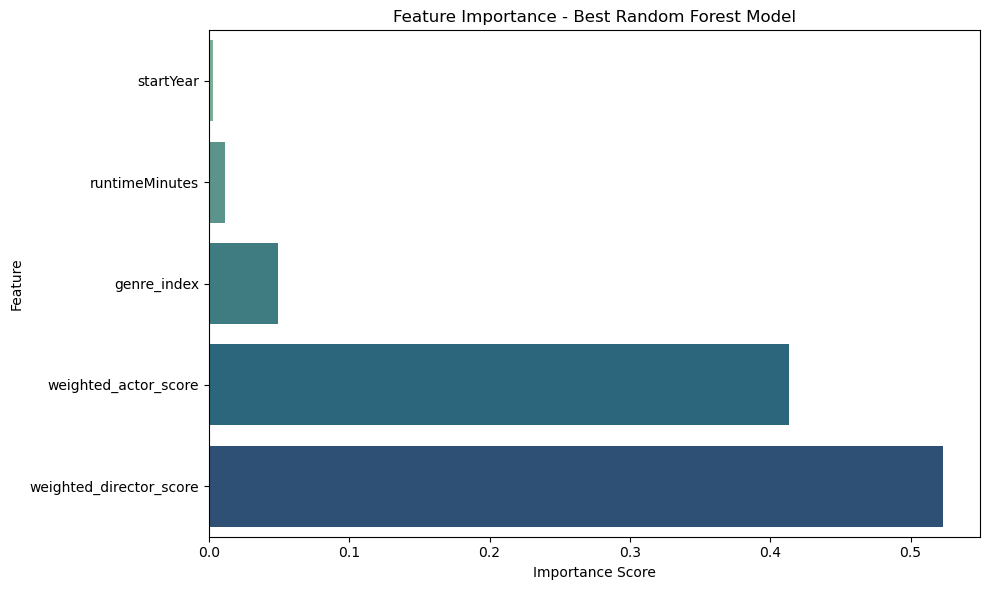

In [12]:
# PLOTTING FEATURE IMPORTANCE CHART FOR WEIGHTS

# GET BEST RANDOM FOREST
rf_model = tvs_model.bestModel.stages[-1]  

# MAKING FEATURES ARRAY
importances = rf_model.featureImportances.toArray()

# MAPPING FEATURES
feature_cols = [
    "genre_index", "runtimeMinutes", "startYear",
    "weighted_director_score", "weighted_actor_score"
]

# CREATING DATAFRAME
importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values(by="importance", ascending=True)

# PLOTTING
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x="importance", y="feature", hue="feature", palette="crest")
plt.title("Feature Importance - Best Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

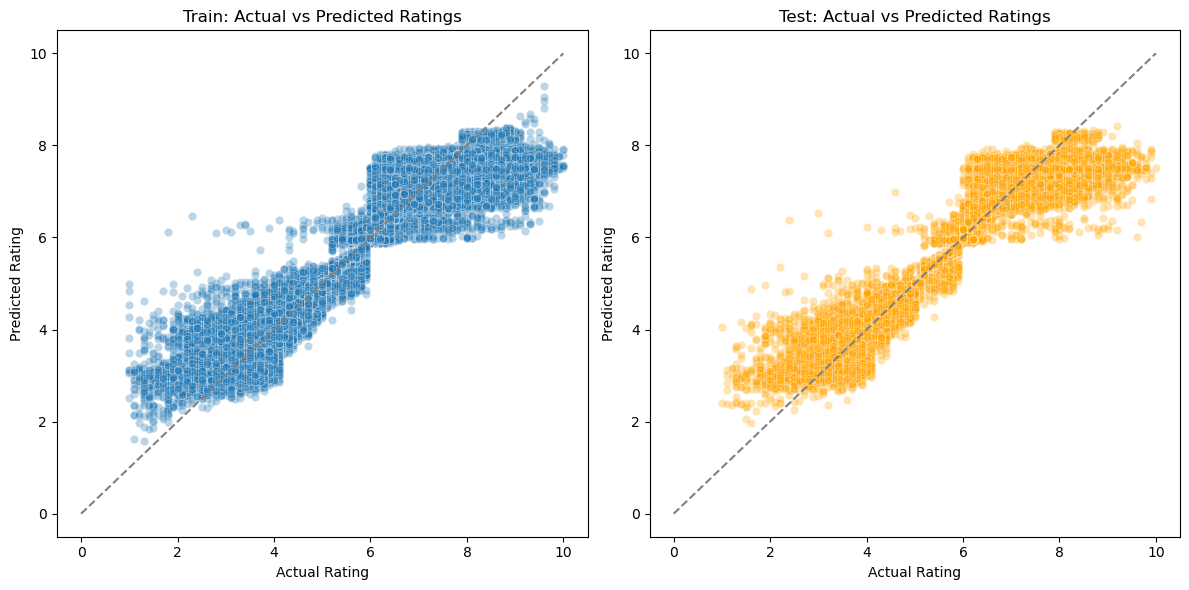

In [13]:
# PLOTTING PREDICTED VS ACTUAL

# CONVERT TO PANDAS
df_train = train_predictions.select("averageRating", "prediction").toPandas()
df_test = test_predictions.select("averageRating", "prediction").toPandas()

# PLOTTING
plt.figure(figsize=(12, 6))

# TRAINING
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_train, x="averageRating", y="prediction", alpha=0.3)
plt.plot([0, 10], [0, 10], '--', color='gray')
plt.title("Train: Actual vs Predicted Ratings")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")

# TEST
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_test, x="averageRating", y="prediction", alpha=0.3, color='orange')
plt.plot([0, 10], [0, 10], '--', color='gray')
plt.title("Test: Actual vs Predicted Ratings")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")

plt.tight_layout()
plt.show()

# Using a weighted score that combines both average rating and number of votes. This gives us a mnore reliable view of the actors, directors, and movie overall performance. 

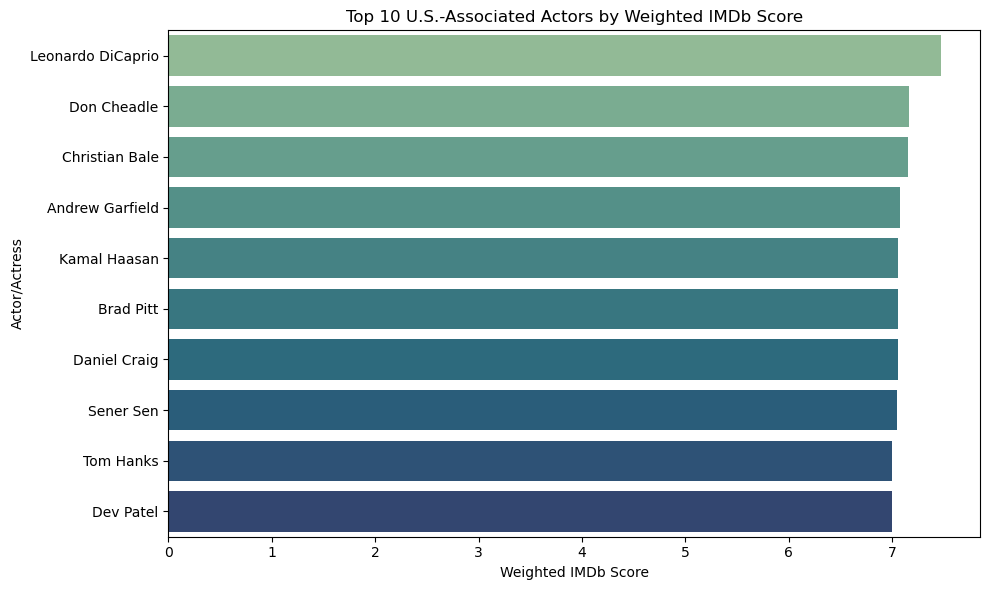

In [14]:
# TOP ACTOR OR ACTRESS BY WEIGH 

# Recalculate actor stats grouped by actor ID (nconst)
actor_stats_weighted = actor_ratings.groupBy("nconst").agg(
    avg("averageRating").alias("avg_rating"),
    sum("numVotes").alias("total_votes"),
    count("tconst").alias("num_titles")
).filter(col("num_titles") >= 5)

# Compute global values for weighting
C = actor_stats_weighted.select(avg("avg_rating")).first()[0]
m = actor_stats_weighted.selectExpr("percentile(total_votes, 0.75)").first()[0]

# ADD CONSTANTS C AND M 
actor_stats_weighted = actor_stats_weighted.withColumn("C", lit(C)).withColumn("m", lit(m))

# COMPUTE WEIGH SCORE
actor_stats_weighted = actor_stats_weighted.withColumn(
    "weighted_score",
    (col("total_votes") / (col("total_votes") + col("m"))) * col("avg_rating") +
    (col("m") / (col("total_votes") + col("m"))) * col("C")
)

# Join actor names
actor_stats_weighted = actor_stats_weighted.join(
    names.select("nconst", "primaryName"),
    on="nconst",
    how="left"
)

# CONVERT TO PANDAS
top_weighted_actors = actor_stats_weighted.orderBy(col("weighted_score").desc())
df_weighted = top_weighted_actors.limit(10).toPandas()
df_weighted["label"] = df_weighted["primaryName"]

# PLOTTING
plt.figure(figsize=(10, 6))
sns.barplot(data=df_weighted, x="weighted_score", y="label", hue="label", palette="crest")
plt.title("Top 10 U.S.-Associated Actors by Weighted IMDb Score")
plt.xlabel("Weighted IMDb Score")
plt.ylabel("Actor/Actress")
plt.tight_layout()
plt.show()

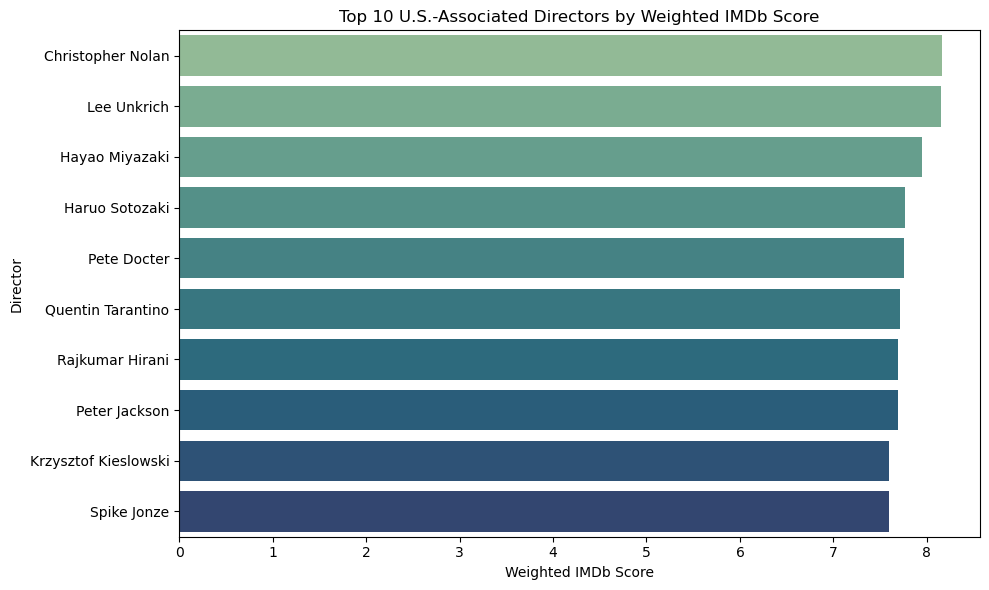

In [15]:
# TOP DIRECTORS BY AVG RATING AND TOTAL VOTES

# Clean crew_with_names (drop duplicate rating columns if present)
crew_clean = crew_with_names.drop("averageRating", "numVotes")

# Join with ratings to get director-level data
director_ratings = crew_clean.join(
    ratings.select("tconst", "averageRating", "numVotes"), on="tconst", how="inner"
)

# Group by director and compute stats
director_stats = director_ratings.groupBy("nconst").agg(
    avg("averageRating").alias("avg_rating"),
    sum("numVotes").alias("total_votes"),
    count("tconst").alias("num_titles")
).filter(col("num_titles") >= 5)

# Global average rating (C) and threshold (m)
C = director_stats.select(avg("avg_rating")).first()[0]
m = director_stats.selectExpr("percentile(total_votes, 0.75)").first()[0]

# ADD CONSTANTS 
director_stats = director_stats.withColumn("C", lit(C)).withColumn("m", lit(m))

# COMPUTE WEIGHTED SCORE 
director_stats = director_stats.withColumn(
    "weighted_score",
    (col("total_votes") / (col("total_votes") + col("m"))) * col("avg_rating") +
    (col("m") / (col("total_votes") + col("m"))) * col("C")
)

# Join with names for label
top_directors = director_stats.join(
    names.select("nconst", "primaryName"), on="nconst", how="left"
)

# PLOTTING
df_directors = top_directors.orderBy(col("weighted_score").desc()).limit(10).toPandas()
df_directors["label"] = df_directors["primaryName"]

plt.figure(figsize=(10, 6))
sns.barplot(data=df_directors, x="weighted_score", y="label", hue="label", palette="crest")
plt.title("Top 10 U.S.-Associated Directors by Weighted IMDb Score")
plt.xlabel("Weighted IMDb Score")
plt.ylabel("Director")
plt.tight_layout()
plt.show()

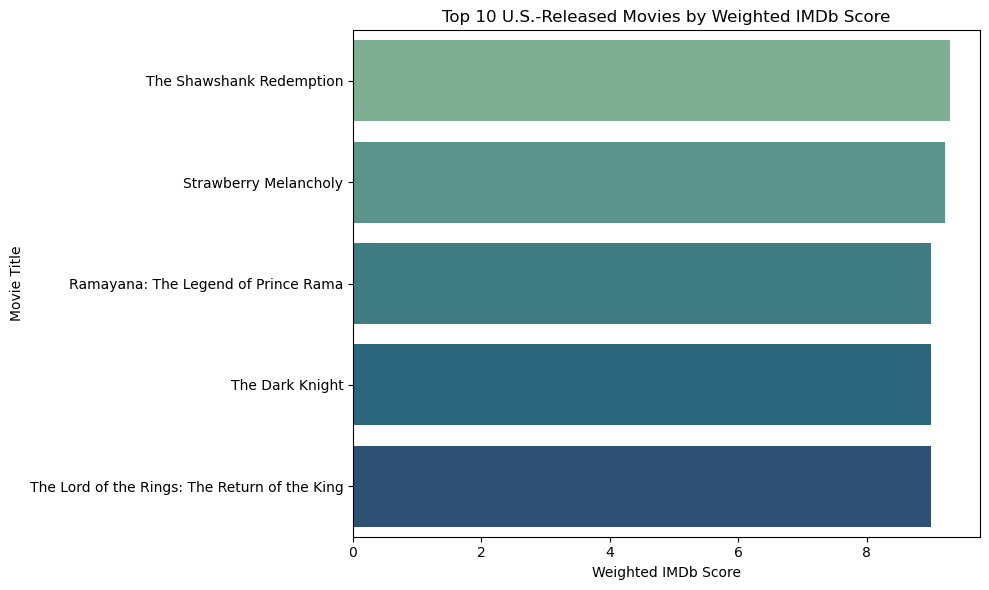

In [16]:
# TOP MOVIES BY AVG RATING AND TOTAL VOTES

# Filter for valid ratings and votes
movie_stats = ml_df.select("tconst", "averageRating", "numVotes") \
    .dropna(subset=["averageRating", "numVotes"])

# Calculate global mean (C) and 60th percentile threshold (m)
C_movie = movie_stats.select(avg("averageRating")).first()[0]
m_movie = movie_stats.selectExpr("percentile(numVotes, 0.6)").first()[0]

# Add C and m to the DataFrame
movie_stats = movie_stats.withColumn("C", lit(C_movie)).withColumn("m", lit(m_movie))

# Compute the weighted IMDb score
movie_stats = movie_stats.withColumn(
    "weighted_score",
    (col("numVotes") / (col("numVotes") + col("m"))) * col("averageRating") +
    (col("m") / (col("numVotes") + col("m"))) * col("C")
)

# Join with movie titles
movie_stats = movie_stats.join(
    basics.select("tconst", "primaryTitle"), on="tconst", how="left"
)

# Sort and select top 10
top_movies = movie_stats.orderBy(col("weighted_score").desc()).limit(10).toPandas()
top_movies["label"] = top_movies["primaryTitle"]

# PLOTTING
plt.figure(figsize=(10, 6))
sns.barplot(data=top_movies, x="weighted_score", y="label", hue="label", palette="crest")
plt.title("Top 10 U.S.-Released Movies by Weighted IMDb Score")
plt.xlabel("Weighted IMDb Score")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.show()

# TREND LINE FOR DIRECTOR AND RATINGS

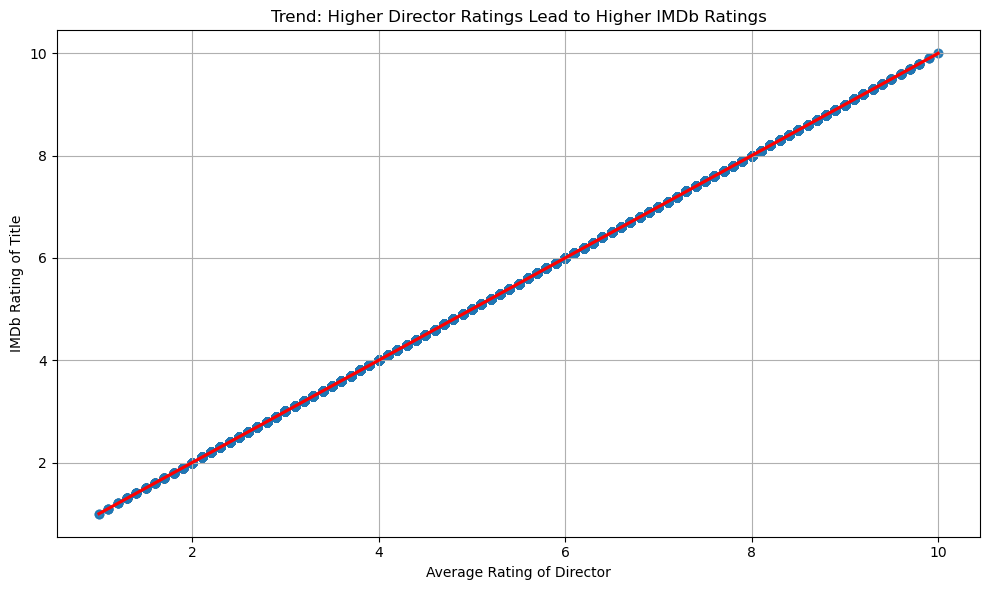

In [17]:
# TREND LINE FOR DIRECTOR AND RATINGS

# Director quality matters: Investing in experienced, highly-rated directors can influence audience reception.

# CREATE DATAFRAME
df_director_trend = ml_df.filter(col("director_avg_rating") > 0) \
    .select("director_avg_rating", "averageRating") \
    .dropna().toPandas()

# PLOTTING
plt.figure(figsize=(10, 6))
sns.regplot(data=df_director_trend, x="director_avg_rating", y="averageRating", 
            scatter_kws={"alpha": 0.2}, line_kws={"color": "red"})
plt.title("Trend: Higher Director Ratings Lead to Higher IMDb Ratings")
plt.xlabel("Average Rating of Director")
plt.ylabel("IMDb Rating of Title")
plt.grid(True)
plt.tight_layout()
plt.show()

# Director and actors = suggest predictors for quality ratings
# Genre/runtime help guide content strategy like type of stories and length "defines the product"

# TOP 5 GENRE POPULARITY OVER TIME 
# Line graph and bar graph

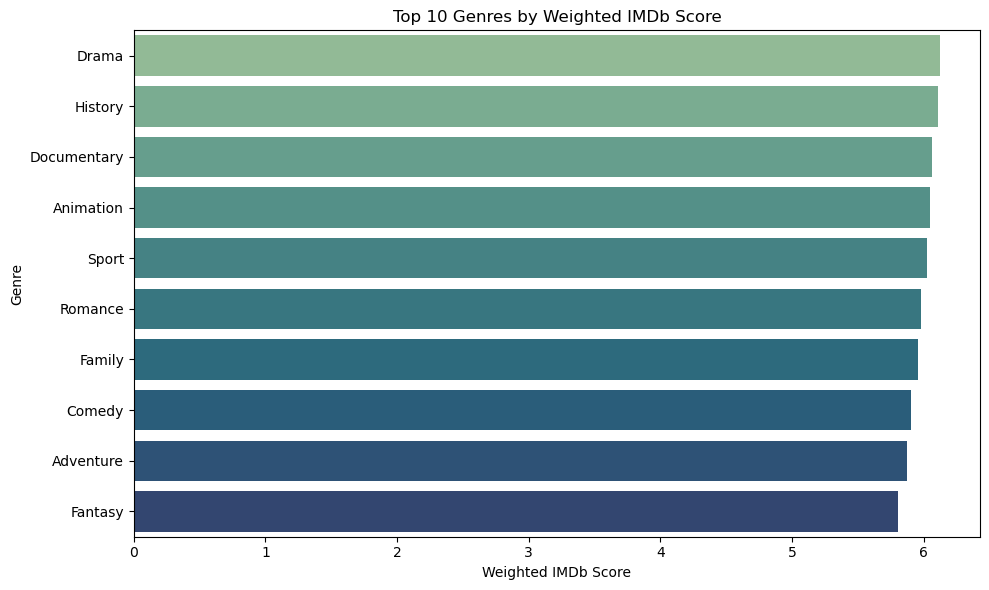

In [18]:
# TOP GENRES BY WEIGHTED SCORE

# Aggregate stats by genre
genre_stats = ml_df.groupBy("genre").agg(
    avg("averageRating").alias("avg_rating"),
    sum("numVotes").alias("total_votes"),
    count("tconst").alias("num_titles")
)

# Global constants
C_genre = genre_stats.select(avg("avg_rating")).first()[0]
m_genre = genre_stats.selectExpr("percentile(total_votes, 0.6)").first()[0]

# Add weighted score components
genre_stats = genre_stats.withColumn("C", lit(C_genre)).withColumn("m", lit(m_genre))

# COMPUTE WEIGHTED SCORE 
genre_stats = genre_stats.withColumn(
    "weighted_score",
    (col("total_votes") / (col("total_votes") + col("m"))) * col("avg_rating") +
    (col("m") / (col("total_votes") + col("m"))) * col("C")
)

# CONVERT TO PANDAS
top_genres = genre_stats.orderBy(col("weighted_score").desc())
df_genres = top_genres.limit(10).toPandas()

# PLOTTING
plt.figure(figsize=(10, 6))
sns.barplot(data=df_genres, x="weighted_score", y="genre", hue="genre", palette="crest")
plt.title("Top 10 Genres by Weighted IMDb Score")
plt.xlabel("Weighted IMDb Score")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

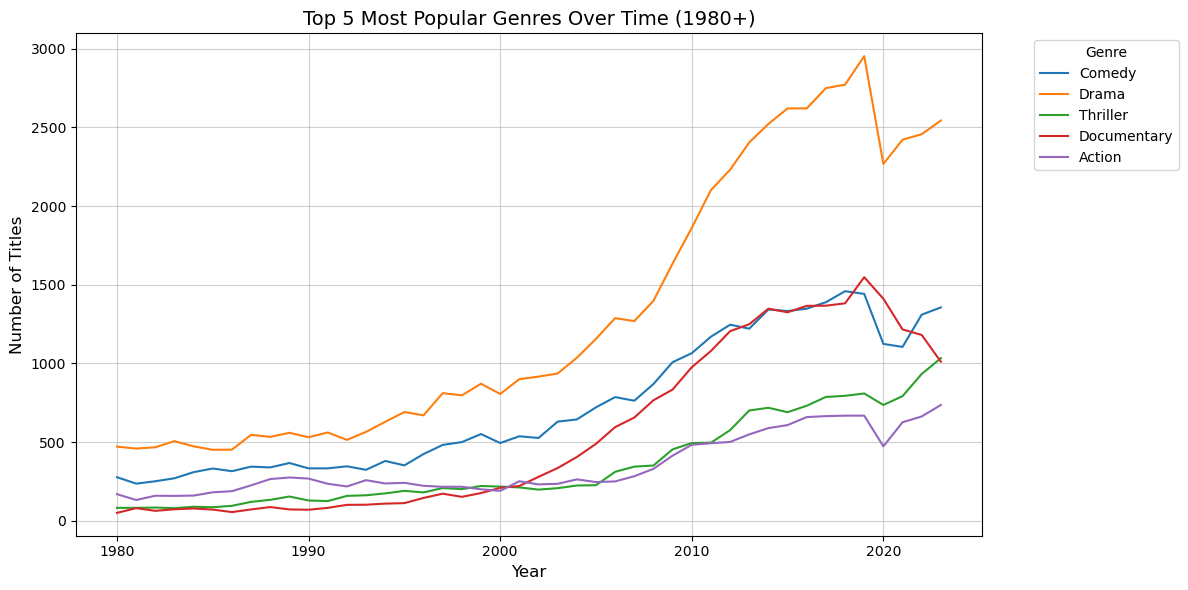

In [19]:
# GENRE POPULARITY OVER TIME

# DEFINE TOP GENRES AGAIN
top_genres = [
    "Drama", "Comedy", "Action", "Romance", "Thriller",
    "Adventure", "Animation", "Family", "Fantasy", "History",
    "Horror", "Sport", "Sci-Fi", "Documentary"
]


# Group by year and genre to count titles
genre_counts = genre_with_ratings.groupBy("startYear", "genre").count()
df_genre = genre_counts.toPandas()

# Clean year and genre filters
df_genre["startYear"] = pd.to_numeric(df_genre["startYear"], errors="coerce")
df_genre = df_genre.dropna(subset=["startYear"])
df_genre["startYear"] = df_genre["startYear"].astype(int)

# COMPUTE TOTAL COUNTS PER GENRE TO GET TOP 5
top5_genres = df_genre.groupby("genre")["count"].sum().nlargest(5).index.tolist()

# FILTER GENRES
df_top5 = df_genre[df_genre["genre"].isin(top5_genres)]
df_top5 = df_top5.sort_values(by="startYear")

# PLOTTING
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top5, x="startYear", y="count", hue="genre")
plt.title("Top 5 Most Popular Genres Over Time (1980+)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Titles", fontsize=12)
plt.grid(True, alpha=0.6)
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

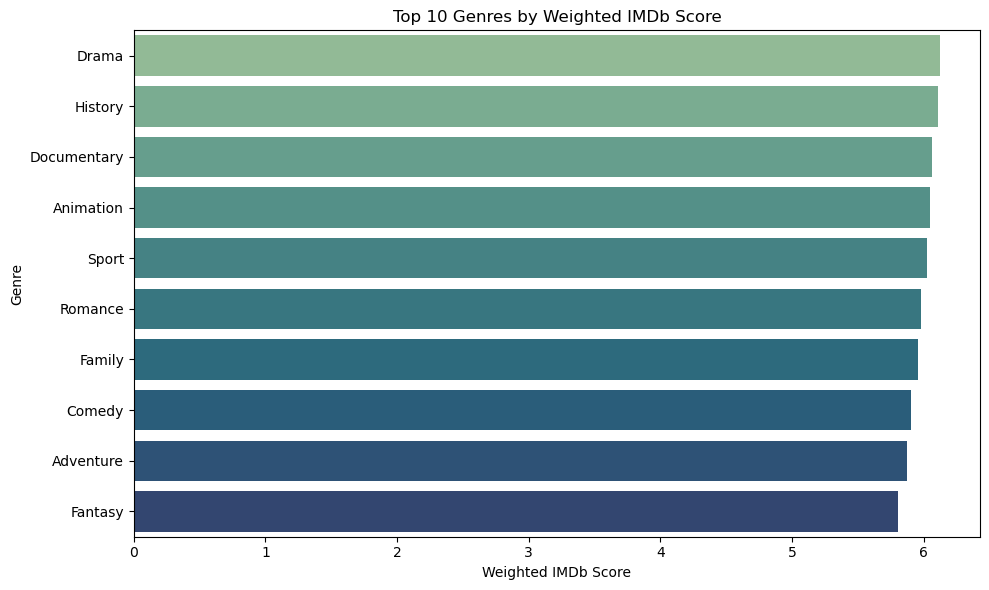

In [20]:
# Group by genre and compute basic stats
genre_stats = genre_with_ratings.filter(
    col("genre").isin(top_genres)
).groupBy("genre") \
.agg(
    avg("averageRating").alias("avg_rating"),
    sum("numVotes").alias("total_votes")
)

# Compute global constants
C_genre = genre_stats.select(avg("avg_rating")).first()[0]
m_genre = genre_stats.selectExpr("percentile(total_votes, 0.6)").first()[0]

# ADD CONSTANTS 
genre_stats = genre_stats.withColumn("C", lit(C_genre)).withColumn("m", lit(m_genre))

# COMPUTE WEIGHTED SCORE 
genre_stats = genre_stats.withColumn(
    "weighted_score",
    (col("total_votes") / (col("total_votes") + col("m"))) * col("avg_rating") +
    (col("m") / (col("total_votes") + col("m"))) * col("C")
)

# SORTING
top_genres_weighted = genre_stats.orderBy(col("weighted_score").desc())
df_genres = top_genres_weighted.limit(10).toPandas()

# PLOTTING
plt.figure(figsize=(10, 6))
sns.barplot(data=df_genres, x="weighted_score", y="genre", hue="genre", palette="crest")
plt.title("Top 10 Genres by Weighted IMDb Score")
plt.xlabel("Weighted IMDb Score")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

# AVERAGE RUNTIME OF MOVIES OVER TIME
# Line graph and bar graphs 

Runtime trends by year (1980 and later)
+---------+-----------------+
|startYear|      avg_runtime|
+---------+-----------------+
|     1980|95.33333333333333|
|     1981|94.47105004906771|
|     1982|95.95932539682539|
|     1983|93.79636711281071|
|     1984|93.74787535410765|
|     1985|94.29952606635071|
|     1986|92.28799249530957|
|     1987|97.93811074918567|
|     1988|93.34530175706647|
|     1989|94.62785388127854|
|     1990|93.18909991742362|
|     1991|94.36521022258863|
|     1992|94.64460784313725|
|     1993| 94.4881329113924|
|     1994|94.47080838323353|
|     1995|94.10316368638239|
|     1996|94.34814814814816|
|     1997|93.63111888111888|
|     1998|93.24226804123711|
|     1999|93.99032258064516|
+---------+-----------------+
only showing top 20 rows



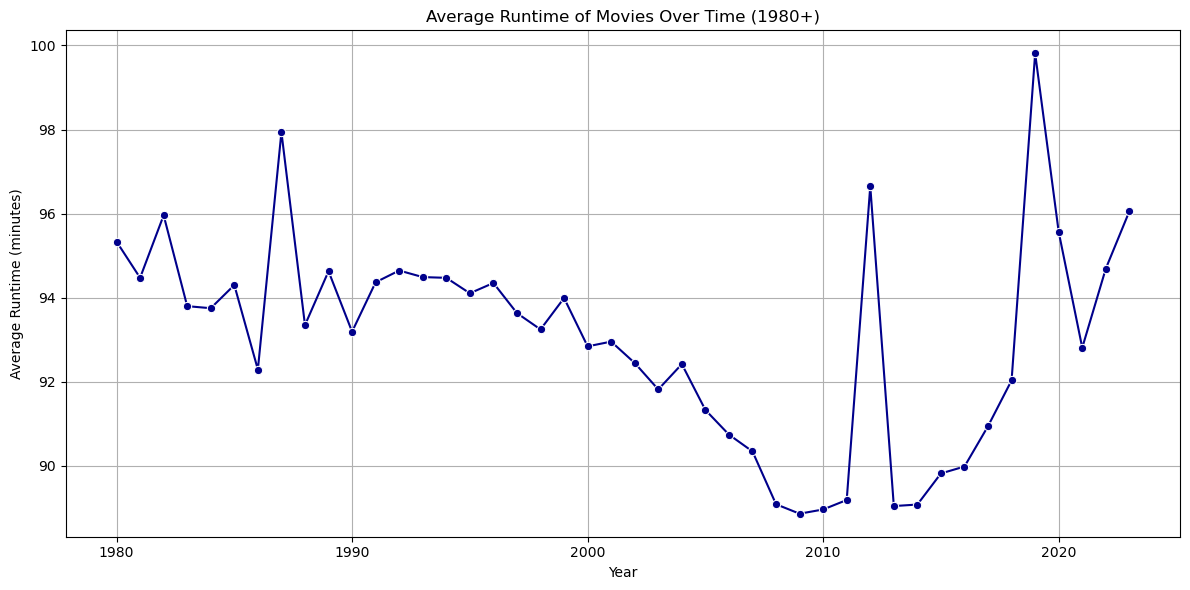

In [21]:
# AVERAGE RUNTIME OF MOVIES OVER TIME

print("Runtime trends by year (1980 and later)")

# GROUP BY YEAR AND CALCULATE AVERAGE RUNTIME 
runtime_by_year = basics.groupBy("startYear") \
    .agg(avg("runtimeMinutes").alias("avg_runtime")) \
    .orderBy("startYear")

runtime_by_year.show(20)

# CONVERT TO PANDAS
df_runtime = runtime_by_year.toPandas()

# PLOTTING
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_runtime, x="startYear", y="avg_runtime", color="darkblue", marker="o")
plt.title("Average Runtime of Movies Over Time (1980+)")
plt.xlabel("Year")
plt.ylabel("Average Runtime (minutes)")
plt.grid(True)
plt.tight_layout()
plt.show()

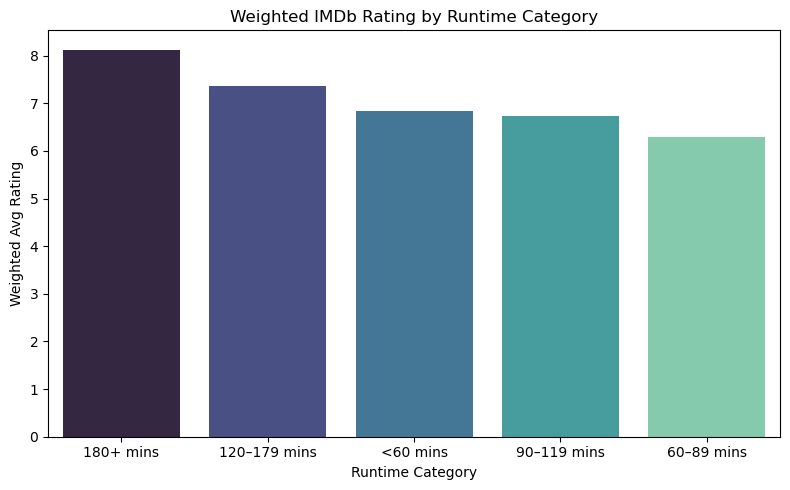

In [28]:
# Weighted IMDb Rating by Runtime Category

rated_filtered = ml_df.select("tconst", "runtimeMinutes", "averageRating", "numVotes") \
    .dropna(subset=["runtimeMinutes", "averageRating", "numVotes"])

# Ensure no duplicate 'numVotes'
rated_filtered = rated_filtered.drop("numVotes")  # drop if already exists

# Join ratings to get fresh 'numVotes'
rated_filtered = rated_filtered.join(
    ratings.select("tconst", "numVotes"), on="tconst", how="left"
)

# Bin runtime into categories
runtime_bins = rated_filtered.withColumn(
    "runtime_bin",
    when(col("runtimeMinutes") < 60, "<60 mins")
    .when((col("runtimeMinutes") >= 60) & (col("runtimeMinutes") < 90), "60–89 mins")
    .when((col("runtimeMinutes") >= 90) & (col("runtimeMinutes") < 120), "90–119 mins")
    .when((col("runtimeMinutes") >= 120) & (col("runtimeMinutes") < 180), "120–179 mins")
    .otherwise("180+ mins")
)

# Weighted average rating per runtime bin
weighted_runtime_rating = runtime_bins.groupBy("runtime_bin").agg(
    (sum(col("averageRating") * col("numVotes")) / sum("numVotes")).alias("weighted_avg_rating"),
    count("tconst").alias("count")
).orderBy("weighted_avg_rating", ascending=False)

# CONVERT TO PANDAS
df_weighted = weighted_runtime_rating.toPandas()

# PLOTTING
plt.figure(figsize=(8, 5))
sns.barplot(data=df_weighted, x="runtime_bin", y="weighted_avg_rating", hue="runtime_bin", palette="mako", legend=False)
plt.title("Weighted IMDb Rating by Runtime Category")
plt.xlabel("Runtime Category")
plt.ylabel("Weighted Avg Rating")
plt.tight_layout()
plt.show()

# Heatmap of Weighted IMDb Ratings by Genre And Decades

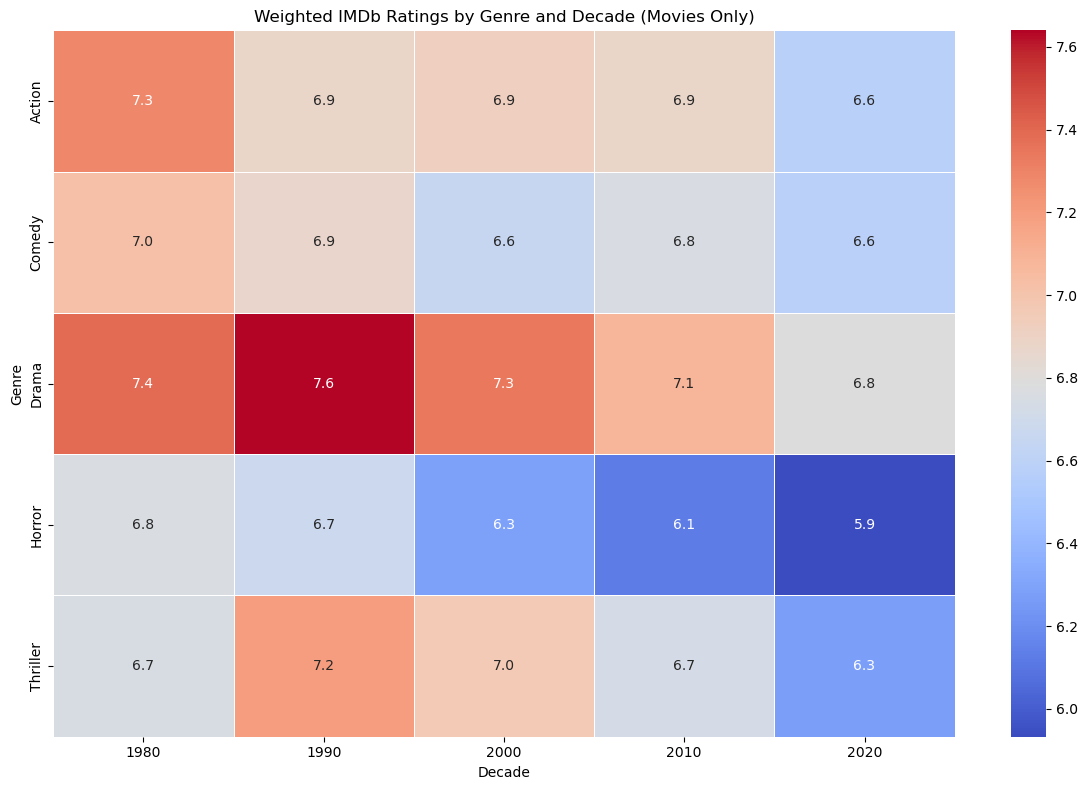

In [23]:
# HEATMAP 

# Group by decade + genre using a weighted formula
genre_decades_ratings = genre_with_decade.filter(
    col("titleType") == "movie"
).groupBy("decade", "genre").agg(
    (sum(col("averageRating") * col("numVotes")) / sum("numVotes")).alias("weighted_avg_rating"),
    sum("numVotes").alias("total_votes")
).filter(col("total_votes") > 10000)

# FILTER GENRES
selected_genres = ["Drama", "Comedy", "Action", "Thriller", "Horror"]
genre_decades_ratings = genre_decades_ratings.filter(
    col("genre").isin(selected_genres)
)

# CONVERT TO PANDAS
df_decade_ratings = genre_decades_ratings.toPandas()

# CREATE PIVOT TABLE
pivot = df_decade_ratings.pivot(index="genre", columns="decade", values="weighted_avg_rating")

# PLOTTING
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)
plt.title("Weighted IMDb Ratings by Genre and Decade (Movies Only)")
plt.xlabel("Decade")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

# Weighted IMDb Ratings by Genre Across Decades

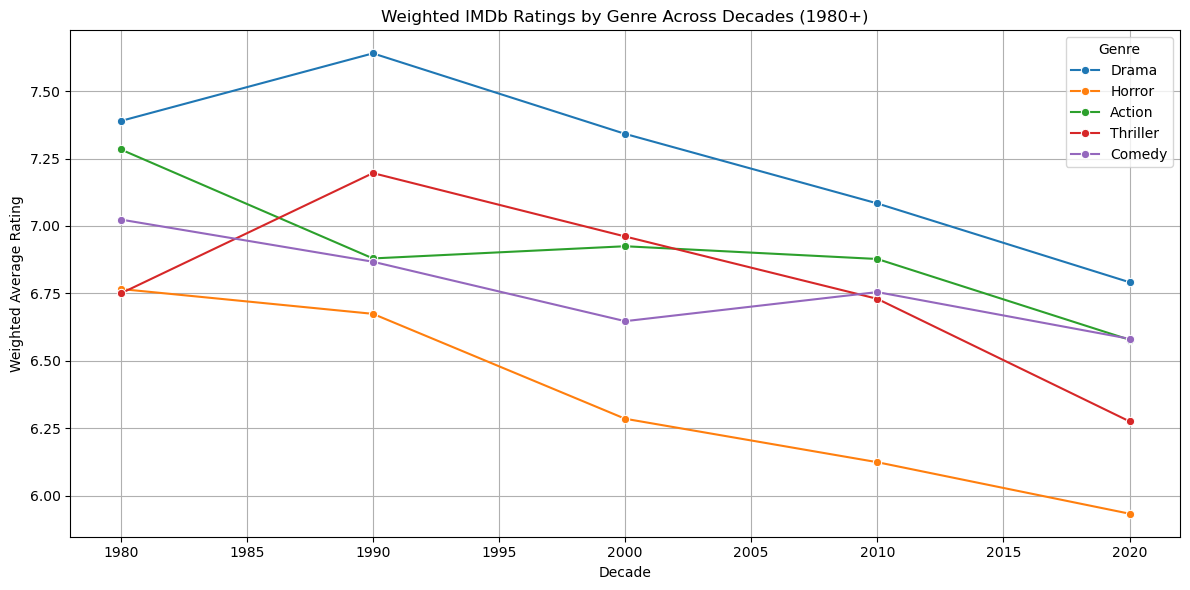

In [24]:
# WEIGHTED IMDB RATINGS BY GENRE ACROSS DECADES 

# FILTER TO GENRES AND DECADES >= 1980 
df_lines = df_decade_ratings[
    (df_decade_ratings["genre"].isin(selected_genres)) &
    (df_decade_ratings["decade"] >= 1980) &
    (df_decade_ratings["decade"] <= 2023)
]

# PLOTTING
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_lines, x="decade", y="weighted_avg_rating", hue="genre", marker="o")
plt.title("Weighted IMDb Ratings by Genre Across Decades (1980+)")
plt.xlabel("Decade")
plt.ylabel("Weighted Average Rating")
plt.legend(title="Genre")
plt.grid(True)
plt.tight_layout()
plt.show()

# Overall average IMDb rating across all genres (weighted)

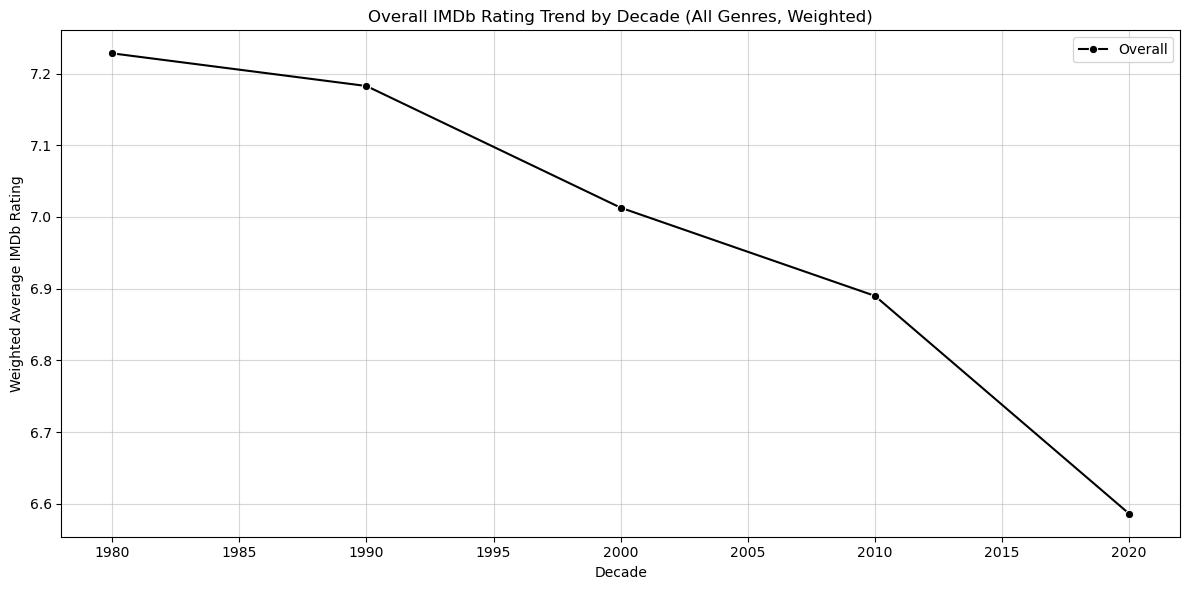

In [25]:
# Overall average IMDb rating across all genres (weighted)

# Group by year and calculate weighted average
overall_trend = ml_df.groupBy("startYear").agg(
    (sum(col("averageRating") * col("numVotes")) / sum("numVotes")).alias("weighted_avg_rating")
).orderBy("startYear")

# CONVERT TO PANDAS
df_overall = overall_trend.toPandas()

# GROUP BY DECADE
df_overall["decade"] = (df_overall["startYear"] // 10) * 10
df_overall_decade = df_overall.groupby("decade").agg(
    weighted_avg_rating=("weighted_avg_rating", "mean")
).reset_index()

# PLOTTING
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_overall_decade, x="decade", y="weighted_avg_rating", marker="o", color="black", label="Overall")

plt.title("Overall IMDb Rating Trend by Decade (All Genres, Weighted)")
plt.xlabel("Decade")
plt.ylabel("Weighted Average IMDb Rating")
plt.grid(True, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Percentage of Animation Genres in Dataset 

In [26]:
# Percentage of Animation Genres in Dataset (seeing if it affects our predictive model)

# COUNT ALL MOVIE-GENRE ROWS FROM ML_DF
total_count = ml_df.select("tconst", "genre").distinct().count()

# COUNT OF ANIMATED LABELED TITLES 
animation_count = ml_df.filter(col("genre") == "Animation").select("tconst").distinct().count()

# COMPUTE PERCENTAGE
animation_percentage = (animation_count / total_count) * 100

print(f"Animation titles: {animation_count}")
print(f"Total unique movie-genre entries: {total_count}")
print(f"Percentage of animation: {animation_percentage:.2f}%")

Animation titles: 3473
Total unique movie-genre entries: 206653
Percentage of animation: 1.68%
